# Final project: Board game recommender

## Model building

#### K-means and clustering

In [273]:
# import libraries
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import cluster 

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import random
from random import randint
from time import sleep

from pandas import json_normalize
pd.set_option("display.max_columns", 0) #no limit to cols we want to see

import pickle

games = pd.read_pickle('./pickles/board_games.pkl')

In [274]:
# visualize data
games.head(20)

,bgg_id,name,year,game_type,min_players,max_players,min_age,min_time,max_time,category,mechanic,complexity
0,1,Die Macher,1986,Strategy Game,3,5,14,240,240,"Economic,Negotiation,Political","Alliances,Area Majority / Influence,Auction/Bi...",4
1,2,Dragonmaster,1981,Strategy Game,3,4,12,30,30,"Card Game,Fantasy",Trick-taking,1
2,3,Samurai,1998,Strategy Game,2,4,10,30,60,"Abstract Strategy,Medieval","Area Majority / Influence,Hand Management,Hexa...",2
3,4,Tal der Könige,1992,Strategy Game,2,4,12,60,60,Ancient,"Action Points,Area Majority / Influence,Auctio...",2
4,5,Acquire,1964,Strategy Game,2,6,12,90,90,"Economic,Territory Building","Hand Management,Investment,Market,Square Grid,...",2
5,6,Mare Mediterraneum,1989,Uncategorized,2,6,12,240,240,"Civilization,Nautical",Dice Rolling,3
6,7,Cathedral,1978,Abstract Game,2,2,8,20,20,"Abstract Strategy,Children's Game,City Buildin...","Enclosure,Pattern Building,Pattern Recognition...",1
7,8,Lords of Creation,1993,Uncategorized,2,5,12,120,120,"Civilization,Fantasy",Modular Board,2
8,9,El Caballero,1998,Strategy Game,2,4,13,90,90,Exploration,"Area Majority / Influence,Tile Placement",3
9,10,Elfenland,1998,Family Game,2,6,10,60,60,"Fantasy,Travel","Hand Management,Network and Route Building,Ope...",2


In [4]:
games.columns
# we will remove id, name and year for the scaling and encoding

Index(['bgg_id', 'name', 'year', 'game_type', 'min_players', 'max_players',
       'min_age', 'min_time', 'max_time', 'category', 'mechanic',
       'complexity'],
      dtype='object')

In [5]:
# break down lists for top 20 values in category

res = []
for i, elem in enumerate(games["category"].to_list()):
    res.extend([''.join(filter(str.isalnum, e)).lower() for e in elem.split(sep=",")]) 


# make a new df to read better
df2 = pd.DataFrame()
df2 = df2.assign(listedWords=Counter(res).keys(),    # list each unique elements
                occurences=Counter(res).values())   # list occurences
df2.sort_values(by='occurences', ascending=False).head(20)

,listedWords,occurences
3,cardgame,11875
28,wargame,8660
4,fantasy,4560
11,childrensgame,4365
20,dice,4139
5,abstractstrategy,3598
40,partygame,3575
18,sciencefiction,3129
22,printplay,2953
21,fighting,2861


In [6]:
# break down lists for top 20 values in mechsx

res = []
for i, elem in enumerate(games["mechanic"].to_list()):
    res.extend([''.join(filter(str.isalnum, e)).lower() for e in elem.split(sep=",")]) 


# make a new df to read better
df3 = pd.DataFrame()
df3 = df3.assign(listedWords=Counter(res).keys(),    # list each unique elements
                occurences=Counter(res).values())   # list occurences
df3.sort_values(by='occurences', ascending=False).head(20)

,listedWords,occurences
3,dicerolling,12926
4,handmanagement,7719
9,setcollection,5631
7,hexagongrid,5060
50,simulation,4420
35,rollspinandmove,4313
36,variableplayerpowers,4256
22,opendrafting,3877
10,tileplacement,3172
39,gridmovement,3104


In [7]:
# split lists of values in catgs mechs and types to getdummied
games.category = games['category'].str.split(',')
games.mechanic = games['mechanic'].str.split(',')
games.game_type = games['game_type'].str.split(',')

##### Preparing X

In [8]:
X = games.drop(['bgg_id', 'name', 'year'], axis=1)

In [9]:
X_num = X.select_dtypes(np.number)
X_cat = X.select_dtypes(object)

In [10]:
X_num.columns
X_cat.columns

Index(['game_type', 'category', 'mechanic'], dtype='object')

In [11]:
# normalizing numericals
transformer = MinMaxScaler().fit(X_num) 
X_norm = transformer.transform(X_num) 

X_normalized = pd.DataFrame(X_norm, columns=X_num.columns)
X_normalized


,min_players,max_players,min_age,min_time,max_time,complexity
0,0.06250,0.004004,0.448276,0.003975,0.002845,0.75
1,0.06250,0.003003,0.379310,0.000482,0.000345,0.25
2,0.03125,0.003003,0.310345,0.000482,0.000702,0.25
3,0.03125,0.003003,0.379310,0.000981,0.000702,0.50
4,0.03125,0.005005,0.379310,0.001480,0.001060,0.25
...,...,...,...,...,...,...
43087,0.03125,0.001001,0.379310,0.000399,0.000345,0.25
43088,0.00000,0.005005,0.448276,0.000981,0.001417,0.25
43089,0.00000,0.000000,0.379310,0.000981,0.000940,0.25
43090,0.03125,0.001001,0.241379,0.000316,0.000226,0.25


In [12]:
# we use getdummies instead of encoding in this case
# takes the list and joins it with a | instead of ,
# it'll go getdummies

# getdummied catg
X_cat = X_cat.drop('category',1).join(X_cat.category.str.join('|').str.get_dummies())
X_cat

,game_type,mechanic,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,...,Memory,Miniatures,Modern Warfare,Movies / TV / Radio theme,Murder/Mystery,Music,Mythology,Napoleonic,Nautical,Negotiation,Novel-based,Number,Party Game,Pike and Shot,Pirates,Political,Post-Napoleonic,Prehistoric,Print & Play,Puzzle,Racing,Real-time,Religious,Renaissance,Science Fiction,Space Exploration,Spies/Secret Agents,Sports,Territory Building,Trains,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,[Strategy Game],"[Alliances, Area Majority / Influence, Auction...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[Strategy Game],[Trick-taking],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,[Strategy Game],"[Area Majority / Influence, Hand Management, H...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[Strategy Game],"[Action Points, Area Majority / Influence, Auc...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[Strategy Game],"[Hand Management, Investment, Market, Square G...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,[Uncategorized],"[Hand Management, Memory, Once-Per-Game Abilit...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
43088,[Uncategorized],"[Dice Rolling, End Game Bonuses, Force Commitm...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
43089,[Uncategorized],[Solo / Solitaire Game],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43090,[Uncategorized],"[Enclosure, Square Grid]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# getdummied mech
X_cat = X_cat.drop('mechanic',1).join(X_cat.mechanic.str.join('|').str.get_dummies(), how='left', lsuffix='_left')
X_cat
#['Deduction', 'Memory', 'Negotiation']
# two cols with the same name in two dfs, we will join them and keep it as is

,game_type,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction_left,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,...,Singing,Single Loser Game,Slide/Push,Solo / Solitaire Game,Speed Matching,Square Grid,Stacking and Balancing,Stat Check Resolution,Static Capture,Stock Holding,Storytelling,Sudden Death Ending,Tags,Take That,Targeted Clues,Team-Based Game,Tech Trees / Tech Tracks,Three Dimensional Movement,Tile Placement,Track Movement,Trading,Traitor Game,Trick-taking,Tug of War,Turn Order: Auction,Turn Order: Claim Action,Turn Order: Pass Order,Turn Order: Progressive,Turn Order: Random,Turn Order: Role Order,Turn Order: Stat-Based,Turn Order: Time Track,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control
0,[Strategy Game],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[Strategy Game],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,[Strategy Game],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[Strategy Game],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[Strategy Game],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,[Uncategorized],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43088,[Uncategorized],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
43089,[Uncategorized],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43090,[Uncategorized],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
#['Deduction', 'Memory', 'Negotiation']
# two cols with the same name in two dfs, we will join them and keep it as is
X_cat['Deduction']+= X_cat['Deduction_left']
X_cat['Memory']+= X_cat['Memory_left']
X_cat['Negotiation']+= X_cat['Negotiation_left']
X_cat.drop(['Deduction_left','Memory_left','Negotiation_left'], axis=1, inplace=True)

In [15]:
X_cat

,game_type,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Singing,Single Loser Game,Slide/Push,Solo / Solitaire Game,Speed Matching,Square Grid,Stacking and Balancing,Stat Check Resolution,Static Capture,Stock Holding,Storytelling,Sudden Death Ending,Tags,Take That,Targeted Clues,Team-Based Game,Tech Trees / Tech Tracks,Three Dimensional Movement,Tile Placement,Track Movement,Trading,Traitor Game,Trick-taking,Tug of War,Turn Order: Auction,Turn Order: Claim Action,Turn Order: Pass Order,Turn Order: Progressive,Turn Order: Random,Turn Order: Role Order,Turn Order: Stat-Based,Turn Order: Time Track,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control
0,[Strategy Game],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[Strategy Game],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,[Strategy Game],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[Strategy Game],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[Strategy Game],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,[Uncategorized],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43088,[Uncategorized],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
43089,[Uncategorized],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43090,[Uncategorized],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# getdummied gametype
X_cat = X_cat.drop('game_type',1).join(X_cat.game_type.str.join('|').str.get_dummies(), how='right', rsuffix='_right')
X_cat

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,...,Storytelling,Sudden Death Ending,Tags,Take That,Targeted Clues,Team-Based Game,Tech Trees / Tech Tracks,Three Dimensional Movement,Tile Placement,Track Movement,Trading,Traitor Game,Trick-taking,Tug of War,Turn Order: Auction,Turn Order: Claim Action,Turn Order: Pass Order,Turn Order: Progressive,Turn Order: Random,Turn Order: Role Order,Turn Order: Stat-Based,Turn Order: Time Track,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control,Abstract Game,Children's Game_right,Customizable,Family Game,Party Game_right,Strategy Game,Thematic,Uncategorized,War Game,nan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43088,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
43089,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43090,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
X_cat["Children's Game"] += X_cat["Children's Game_right"]
X_cat['Party Game'] += X_cat['Party Game_right']
X_cat.drop(["Children's Game_right",'Party Game_right'], axis=1, inplace=True)

In [18]:
X_cat

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,...,Static Capture,Stock Holding,Storytelling,Sudden Death Ending,Tags,Take That,Targeted Clues,Team-Based Game,Tech Trees / Tech Tracks,Three Dimensional Movement,Tile Placement,Track Movement,Trading,Traitor Game,Trick-taking,Tug of War,Turn Order: Auction,Turn Order: Claim Action,Turn Order: Pass Order,Turn Order: Progressive,Turn Order: Random,Turn Order: Role Order,Turn Order: Stat-Based,Turn Order: Time Track,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control,Abstract Game,Customizable,Family Game,Strategy Game,Thematic,Uncategorized,War Game,nan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43088,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
43089,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43090,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [19]:
# concat transformed data for kmeans
X_transformed = pd.concat([X_normalized, X_cat], axis=1)
X_transformed

,min_players,max_players,min_age,min_time,max_time,complexity,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,...,Static Capture,Stock Holding,Storytelling,Sudden Death Ending,Tags,Take That,Targeted Clues,Team-Based Game,Tech Trees / Tech Tracks,Three Dimensional Movement,Tile Placement,Track Movement,Trading,Traitor Game,Trick-taking,Tug of War,Turn Order: Auction,Turn Order: Claim Action,Turn Order: Pass Order,Turn Order: Progressive,Turn Order: Random,Turn Order: Role Order,Turn Order: Stat-Based,Turn Order: Time Track,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control,Abstract Game,Customizable,Family Game,Strategy Game,Thematic,Uncategorized,War Game,nan
0,0.06250,0.004004,0.448276,0.003975,0.002845,0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.06250,0.003003,0.379310,0.000482,0.000345,0.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.03125,0.003003,0.310345,0.000482,0.000702,0.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.03125,0.003003,0.379310,0.000981,0.000702,0.50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.03125,0.005005,0.379310,0.001480,0.001060,0.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0.03125,0.001001,0.379310,0.000399,0.000345,0.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43088,0.00000,0.005005,0.448276,0.000981,0.001417,0.25,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
43089,0.00000,0.000000,0.379310,0.000981,0.000940,0.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43090,0.03125,0.001001,0.241379,0.000316,0.000226,0.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


##### K-means

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [04:44<00:00,  8.12s/it]


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

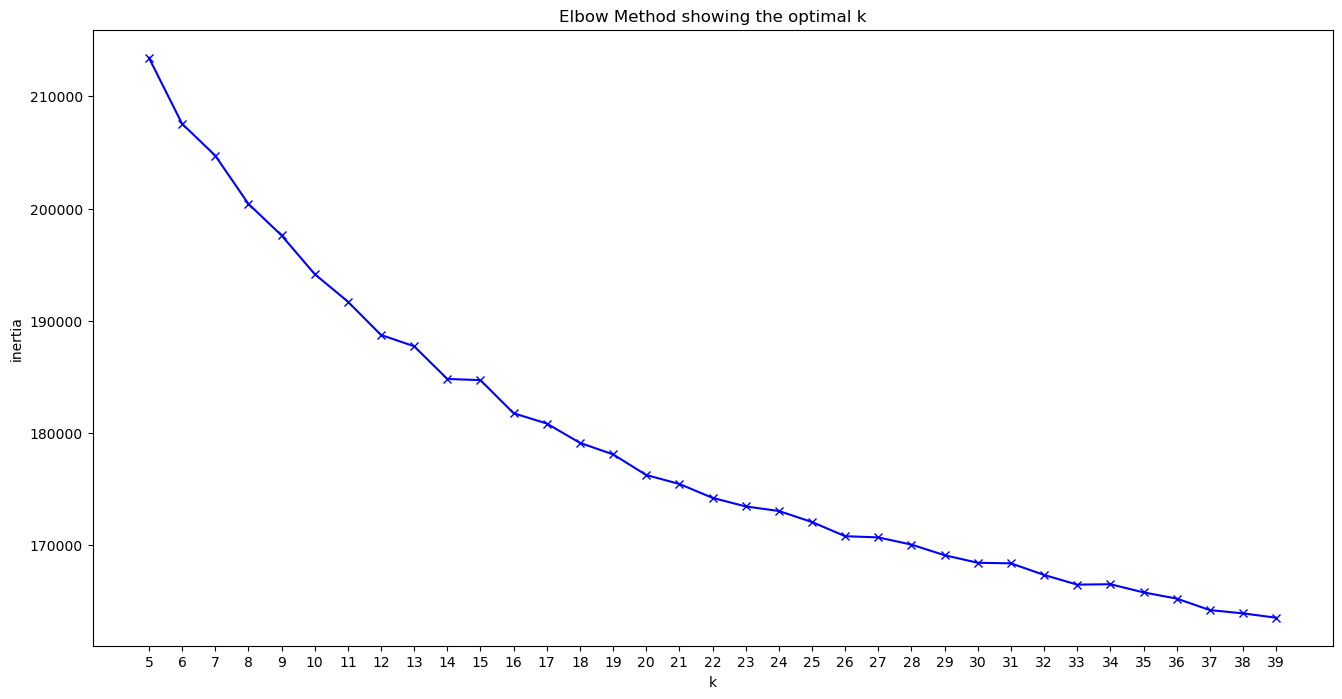

In [22]:
# finding optimal k value via elbow method
K = range(5, 40) #range of clusterings, from 2 to 19
inertia = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_transformed)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

100%|██████████| 30/30 [17:57<00:00, 35.91s/it]


Text(0.5, 1.0, 'Slhouette score showing the optimal k')

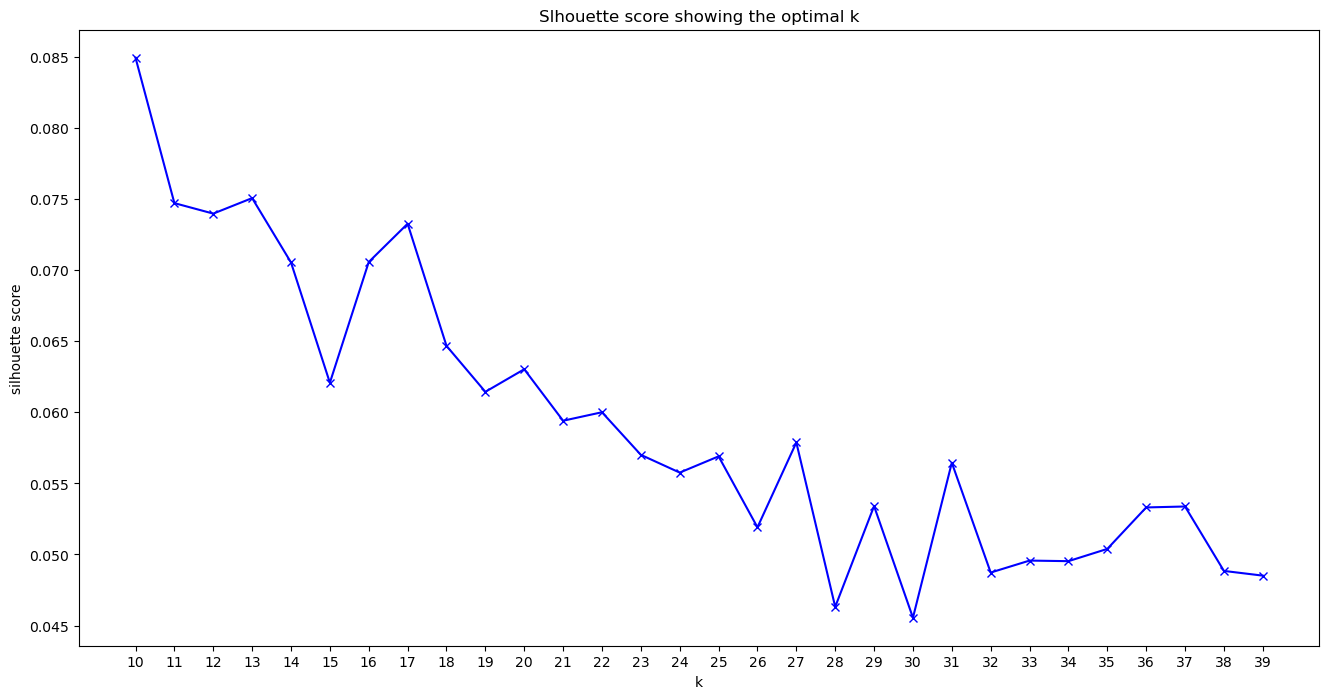

In [21]:
# finding optimal k value via silhouette
K = range(10, 40)
silhouette = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_transformed)
    silhouette.append(silhouette_score(X_transformed, kmeans.predict(X_transformed)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

**Optimal vals:** Our optimal k could be 13 and 17, in a range of 10-40.

***

#### Optimal k number and clusters

`k = 13`

In [27]:
# fitting kmeans
kmeans13 = KMeans(n_clusters=13, random_state=1234)
kmeans13.fit(X_transformed)

KMeans(n_clusters=13, random_state=1234)

In [28]:
# Predicting / assigning the clusters:
predict_13 = kmeans13.predict(X_transformed)
predict_13

# Check the size of the clusters
k_13clusters = pd.Series(predict_13).sort_index()
k_13clusters

0        10
1        10
2        10
3        10
4        10
         ..
43087     6
43088    12
43089     4
43090     4
43091     4
Length: 43092, dtype: int32

`k = 17`

In [29]:
# fitting kmeans
kmeans17 = KMeans(n_clusters=17, random_state=1234)
kmeans17.fit(X_transformed)

KMeans(n_clusters=17, random_state=1234)

In [30]:
# Predicting / assigning the clusters:
predict_17 = kmeans17.predict(X_transformed)
predict_17

# Check the size of the clusters
k_17clusters = pd.Series(predict_17).sort_index()
k_17clusters

0        12
1        12
2        12
3        12
4        12
         ..
43087    14
43088     5
43089    10
43090    10
43091    10
Length: 43092, dtype: int32

#### Save clusters work to our games dataset

In [275]:
games_clustered = games.assign(cluster_13 = k_13clusters, cluster_17 = k_17clusters)
games_clustered

,bgg_id,name,year,game_type,min_players,max_players,min_age,min_time,max_time,category,mechanic,complexity,cluster_13,cluster_17
0,1,Die Macher,1986,Strategy Game,3,5,14,240,240,"Economic,Negotiation,Political","Alliances,Area Majority / Influence,Auction/Bi...",4,10,12
1,2,Dragonmaster,1981,Strategy Game,3,4,12,30,30,"Card Game,Fantasy",Trick-taking,1,10,12
2,3,Samurai,1998,Strategy Game,2,4,10,30,60,"Abstract Strategy,Medieval","Area Majority / Influence,Hand Management,Hexa...",2,10,12
3,4,Tal der Könige,1992,Strategy Game,2,4,12,60,60,Ancient,"Action Points,Area Majority / Influence,Auctio...",2,10,12
4,5,Acquire,1964,Strategy Game,2,6,12,90,90,"Economic,Territory Building","Hand Management,Investment,Market,Square Grid,...",2,10,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,389817,Route 66: Get Your Tricks,2023,Uncategorized,2,2,12,25,30,"Card Game,Transportation,Travel","Hand Management,Memory,Once-Per-Game Abilities...",2,6,14
43088,389997,Bakhmut Meatgrinder: Verdun 2023,2023,Uncategorized,1,6,14,60,120,"Bluffing,Horror,Modern Warfare,Print & Play,Wa...","Dice Rolling,End Game Bonuses,Force Commitment...",2,12,5
43089,390199,Space Privateer Command,2022,Uncategorized,1,1,12,60,80,"Adventure,Dice,Science Fiction",Solo / Solitaire Game,2,4,10
43090,390607,Great Kingdom,2023,Uncategorized,2,2,8,20,20,Abstract Strategy,"Enclosure,Square Grid",2,4,10


In [276]:
# save into pickle to work for pred model
games_clustered.to_pickle('games_withclusters.pkl')
# games_clustered.to_csv('games_for_tableau.csv')

***

#### Test recommendation

In [270]:
games_test = games_clustered
# games_test[['min_players','max_players','min_time','max_time','min_age','complexity']] = games_test[['min_players','max_players','min_time','max_time','min_age','complexity']].astype(int)
games_test['year'] = pd.to_numeric(games_test['year'], errors='coerce', downcast='integer')


In [272]:
games_test.head(50)

,bgg_id,name,year,game_type,min_players,max_players,min_age,min_time,max_time,category,mechanic,complexity,cluster_13,cluster_17
0,1,Die Macher,1986,Strategy Game,3,5,14,240,240,"Economic,Negotiation,Political","Alliances,Area Majority / Influence,Auction/Bi...",4,10,12
1,2,Dragonmaster,1986,Strategy Game,3,4,12,30,30,"Card Game,Fantasy",Trick-taking,2,10,12
2,3,Samurai,1986,Strategy Game,2,4,10,30,60,"Abstract Strategy,Medieval","Area Majority / Influence,Hand Management,Hexa...",2,10,12
3,4,Tal der Könige,1986,Strategy Game,2,4,12,60,60,Ancient,"Action Points,Area Majority / Influence,Auctio...",3,10,12
4,5,Acquire,1986,Strategy Game,2,6,12,90,90,"Economic,Territory Building","Hand Management,Investment,Market,Square Grid,...",2,10,12
5,6,Mare Mediterraneum,1986,Uncategorized,2,6,12,240,240,"Civilization,Nautical",Dice Rolling,3,3,8
6,7,Cathedral,1986,Abstract Game,2,2,8,20,20,"Abstract Strategy,Children's Game,City Buildin...","Enclosure,Pattern Building,Pattern Recognition...",2,8,1
7,8,Lords of Creation,1986,Uncategorized,2,5,12,120,120,"Civilization,Fantasy",Modular Board,2,4,10
8,9,El Caballero,1986,Strategy Game,2,4,13,90,90,Exploration,"Area Majority / Influence,Tile Placement",3,10,12
9,10,Elfenland,1986,Family Game,2,6,10,60,60,"Fantasy,Travel","Hand Management,Network and Route Building,Ope...",2,10,0


In [252]:
# could we stuff it all in one function? try for the future
choice = input('choose or recommend?')
if choice == "i've got a game":
    print('oki doki')
elif choice == 'recommend me pls':
    print('2nd oki doki')
else:
    print('bb u gotta pick')

bb u gotta pick


In [253]:
# test by multiple filters
import string
gtype = input('What kind of game type are you looking for dAHling')
capped = string.capwords(gtype, sep = None)
players = int(input('How many people are playing?'))
time = int(input('How long do you have to play? (in mins)'))

def game_rec_by_filters(choice, df):
    gt = df[(df.game_type.isin([gtype])) | (df.category.isin([gtype])) | (df.mechanic.isin([gtype]))]
    # create boolean mask to check range
    pl_mask = gt.apply(lambda row: row['min_players'] <= players <= row['max_players'], axis=1)
    ti_mask = gt.apply(lambda row: row['min_time'] <= time <= row['max_time'], axis=1)
    # apply boolean mask to filtered rows
    pl = gt[pl_mask]
    ti = pl[ti_mask]
    # get a random game from that filter
    if ti.empty:
        print("So sorry bestie, we got nothing for you.")
    else:
        random_idx = random.randint(0, len(ti)-1)
        print(f'''Here's something you could like bb:  
                {ti['name'].iloc[random_idx]},
                a game about
                {ti['category'].iloc[random_idx].split(',')[0]} for up to 
                {int(ti['max_players'].iloc[random_idx])} players''')

In [245]:
game_rec_by_filters(capped, players, time, games_test)

Here's something you could like bb:  
                Totally Gross,
                a game about
                Children's Game for up to 
                4 players


In [238]:
# test with user input
import string
game = input('What game do you like dAHling')
capped = string.capwords(game, sep = None)

# point it to a cluster where that game belongs to
target = games_clustered[games_clustered['name'] == capped]['cluster_13'].iloc[0]

# show cluster with the rest of games
cluster = games_clustered[games_clustered['cluster_13'] == target]

# get a random game from that cluster
random_idx = random.randint(0, len(cluster)-1)
print("Here's something you could like bb:", 
    cluster['name'].iloc[random_idx],
    ", an",
    cluster['category'].iloc[random_idx][0], "game for",
    int(cluster['max_players'].iloc[random_idx]), "players")


In [266]:
# test with user input
import string
game = input('What game do you like dAHling')
capped = string.capwords(game, sep = None)

def game_rec_by_clusters(user_game, df):
    # point it to a cluster where that game belongs to
    try:
        target = df[df['name'] == user_game]['cluster_13'].iloc[0]
        # show cluster with the rest of games
        cluster = df[df['cluster_13'] == target]        
        # get a random game from that cluster
        random_idx = random.randint(0, len(cluster)-1)
        print(f'''Here's something you could like bb:  
                {cluster['name'].iloc[random_idx]},
                a game about
                {cluster['category'].iloc[random_idx].split(',')[0]} for up to 
                {int(cluster['max_players'].iloc[random_idx])} players''')
    except IndexError:
        print('sorry! we do not have that. Try again?')

In [267]:
game_rec_by_clusters(capped, games_clustered)

sorry! we do not have that. Try again?
